In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
%matplotlib inline
from sklearn.metrics import silhouette_score
# To Scale our data
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
gdp = pd.read_csv("C://Users/pchadha/Prediction_Modeling/Cluster_PCA_assignment/Country-data.csv")

In [4]:
gdp.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


EDA and Data preparation
Searching for null or missing values

In [8]:
gdp.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

It can be seen that there are no missing values 

In [24]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


Total 167 entries and all columns consist of 167 non-null entries and data types seem to correctly represent the respective columns 

Converting the 'exports', 'health', 'imports' from percentage values, relative to total GDP, to actual values. We will have to consider GDP per capita only instead of total GDP as that's the only detail available. 

In [14]:
gdp.exports = round((gdp.exports*gdp.gdpp)/100,2)

In [16]:
gdp.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,6.03,58.9,19100,1.44,76.8,2.13,12200


In [17]:
gdp.health = round((gdp.health*gdp.gdpp)/100,2)

In [18]:
gdp.imports = round((gdp.imports*gdp.gdpp)/100,2)

In [19]:
gdp.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


In [126]:
gdp[gdp.duplicated()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp


It can be seen that there are no duplicate entries

Outlier analysis

In [10]:
gdp.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


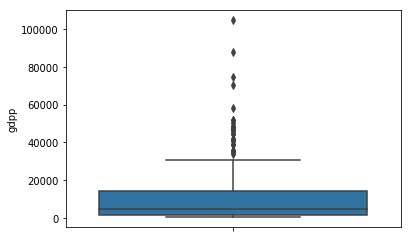

In [13]:
sns.boxplot(gdp.gdpp, orient = 'v')

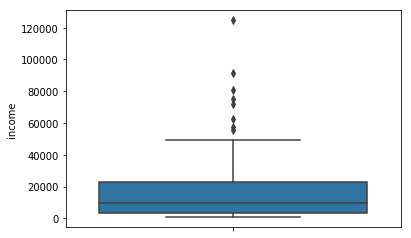

In [294]:
sns.boxplot(gdp.income, orient = 'v')

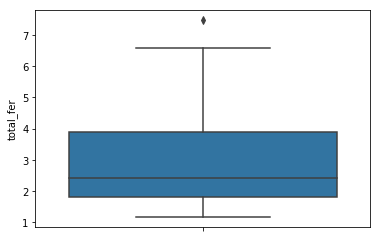

In [295]:
sns.boxplot(gdp.total_fer, orient = 'v')

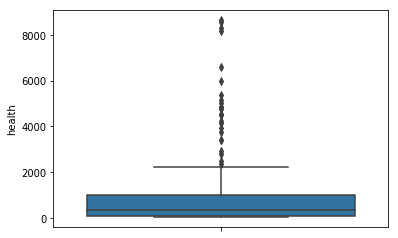

In [22]:
sns.boxplot(gdp.health, orient = 'v')

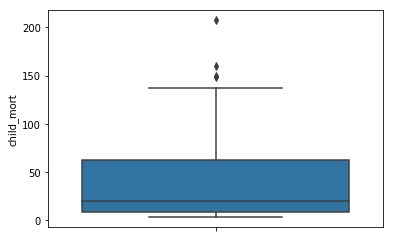

In [23]:
sns.boxplot(gdp.child_mort, orient = 'v')

It can be seen that outliers do exist in all the variables for which distribution has been visualized using box plot. Though we need to identify the countries that need the funding most based on the comparatively lower GDP, poorer health, import, export and lower factors such as income, will not reduce the data set by removing outliers before the scaling and PCA process.    

Taking the dataframe columns minus the 'country' column as we will not be using this column while doing PCA and model analysis. Once cluster details are available, we will include the 'country' column so as to map the relevant counries to the required cluster 

In [27]:
numerics = ['int64', 'float64']
col = gdp.select_dtypes(include=numerics).columns.values

In [28]:
gdpm = gdp[col]

In [29]:
gdpm.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


Standardizing the data using standard scaler, i.e., scaling the data so that mean of varibales is zero and standard deviation is 1 

In [30]:
st = StandardScaler()

In [37]:
gdpms = st.fit_transform(gdpm) 

C:\Users\pchadha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\pchadha\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [39]:
gdpm.columns.values

array(['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'], dtype=object)

In [40]:
gdpms = pd.DataFrame(gdpms, columns = gdpm.columns.values)

In [41]:
# Standardized dataframe
gdpms

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.411011,-0.565038,-0.432275,-0.808245,0.157336,-1.619092,1.902882,-0.679180
1,-0.538949,-0.350191,-0.439215,-0.313677,-0.375369,-0.312347,0.647866,-0.859973,-0.485623
2,-0.272833,-0.318526,-0.484827,-0.353720,-0.220844,0.789274,0.670423,-0.038404,-0.465376
3,2.007808,-0.291375,-0.532366,-0.345953,-0.585043,1.387054,-1.179234,2.128151,-0.516268
4,-0.695634,-0.104331,-0.178771,0.040735,0.101732,-0.601749,0.704258,-0.541946,-0.041817
5,-0.591177,-0.305464,-0.123849,-0.336841,0.080920,1.244725,0.591474,-0.382933,-0.145791
6,-0.501643,-0.376722,-0.509493,-0.349751,-0.543421,-0.001123,0.309514,-0.833471,-0.533233
7,-0.832423,0.159352,1.934367,0.290369,1.261966,-0.628316,1.290735,-0.674457,2.130699
8,-0.844858,0.928521,2.284104,1.079305,1.355617,-0.655549,1.121559,-0.999109,1.857082
9,0.023128,-0.237137,-0.397183,-0.366781,-0.059556,0.571037,-0.164178,-0.681083,-0.389857


Plotting the correlation matrix to get the idea of correlation between the variables

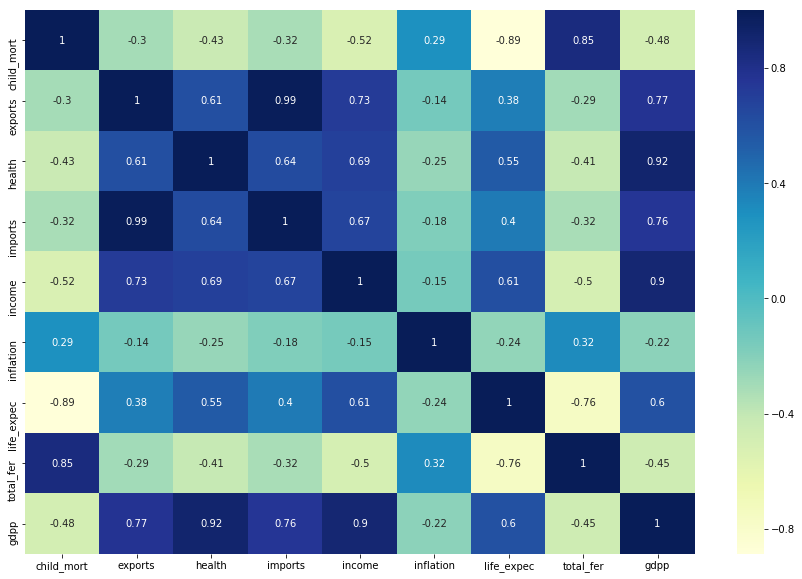

In [47]:
plt.figure(figsize = (15, 10))
sns.heatmap(gdpms.corr(), annot = True, cmap="YlGnBu")
plt.show()

While it was expected that 'exports', 'health' and 'imports' would be highly correlated with 'gdpp', 'income' and 'life_expec' are the other two major correlated variables with 'gdpp'.
Also, 'life_expec' is higly negatively correlated to 'child_mort' and 'total_fer', which goes with the defination of these columns as well

Now that we have the standardized dataframe, will run PCA to identify the most important variables to be used for clustering.   

In [42]:
#PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [43]:
pca.fit(gdpms)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [44]:
pca.components_

array([[-0.31639186,  0.34288671,  0.35853499,  0.34486492,  0.38004113,
        -0.14308532,  0.34385651, -0.30284223,  0.39998795],
       [ 0.47626736,  0.39731091,  0.15505293,  0.37078074,  0.12838447,
         0.22126086, -0.36981973,  0.45971522,  0.2006241 ],
       [-0.15001226, -0.03057357, -0.07570343, -0.07217375,  0.14576424,
         0.94841867,  0.19675172, -0.07783434,  0.0103394 ],
       [-0.14805185,  0.44942527, -0.59971229,  0.46179778, -0.15480589,
        -0.00762818, -0.01839485, -0.21392819, -0.36477234],
       [ 0.10199508, -0.03853838, -0.49319955, -0.25278675,  0.79407463,
        -0.1364234 , -0.15404182, -0.02033659,  0.08750161],
       [ 0.19658514, -0.03891118,  0.18069951, -0.01217966, -0.03814788,
         0.10840303, -0.58600962, -0.75390071,  0.04538188],
       [ 0.76126724, -0.01366973, -0.06461567,  0.02718245, -0.02311309,
        -0.02207665,  0.5812085 , -0.27314529, -0.04402268],
       [ 0.00644412, -0.05526367,  0.43007215,  0.13113546,  0

We can see that there are 9 PCA components, same number as the total number of original variables

In [45]:
# Checking the explained variance ratio
pca.explained_variance_ratio_

array([5.89372979e-01, 1.84451687e-01, 9.91147192e-02, 6.07227850e-02,
       3.02917271e-02, 2.45982648e-02, 9.39743693e-03, 1.55641982e-03,
       4.93981448e-04])

In [88]:
pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3] + pca.explained_variance_ratio_[4]

0.9639538970491158

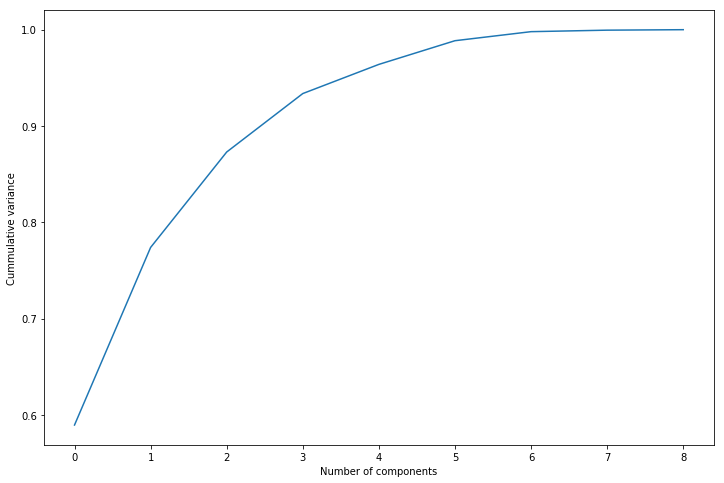

In [46]:
# Plotting the cummulative variance and number of PCs graph to identify the correct number of PCs required to explain 95% of variance
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cummulative variance")
plt.show()

It can be seen that 5 PCs explain in total of approximately 96% variance

In [50]:
#Understanding how the original variables are loaded on the principal components. It can be verified from above as well.
colnames = list(gdpms.columns)
pcs_df = pd.DataFrame({ 'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'PC4':pca.components_[3],'PC5':pca.components_[4]})
pcs_df

,Feature,PC1,PC2,PC3,PC4,PC5
0,child_mort,-0.316392,0.476267,-0.150012,-0.148052,0.101995
1,exports,0.342887,0.397311,-0.030574,0.449425,-0.038538
2,health,0.358535,0.155053,-0.075703,-0.599712,-0.493200
3,imports,0.344865,0.370781,-0.072174,0.461798,-0.252787
4,income,0.380041,0.128384,0.145764,-0.154806,0.794075
5,inflation,-0.143085,0.221261,0.948419,-0.007628,-0.136423
6,life_expec,0.343857,-0.369820,0.196752,-0.018395,-0.154042
7,total_fer,-0.302842,0.459715,-0.077834,-0.213928,-0.020337
8,gdpp,0.399988,0.200624,0.010339,-0.364772,0.087502


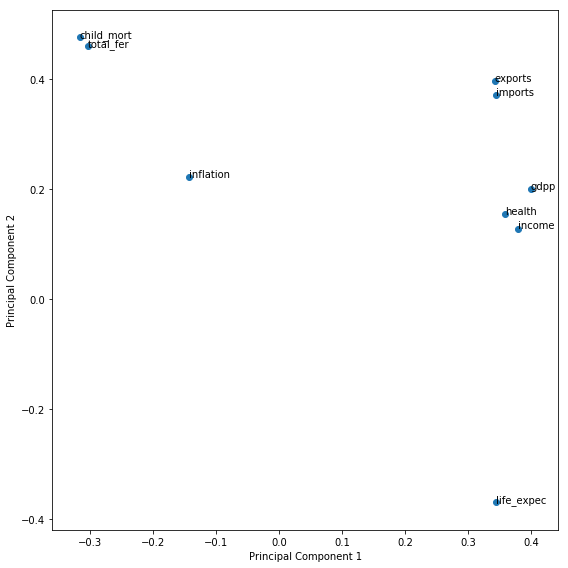

In [51]:
# Will plot the first two PCs to visualise how these features are loaded against these two
%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

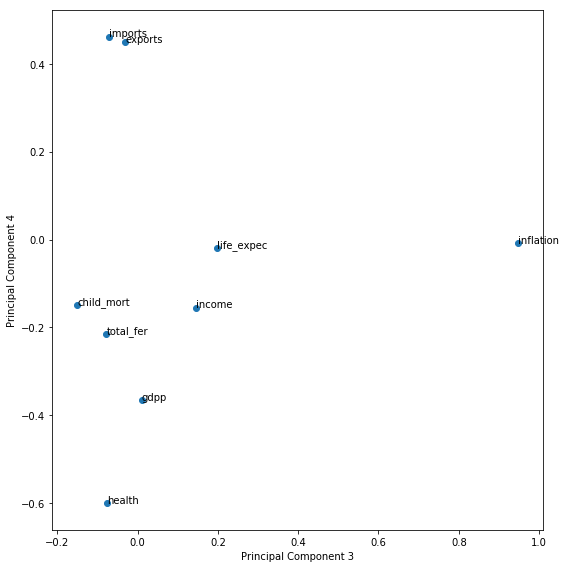

In [53]:
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC3, pcs_df.PC4)
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC3[i],pcs_df.PC4[i]))
plt.tight_layout()
plt.show()

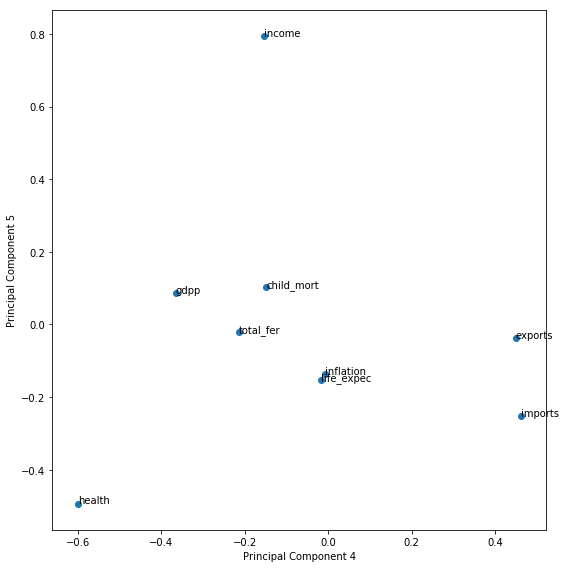

In [54]:
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df.PC4, pcs_df.PC5)
plt.xlabel('Principal Component 4')
plt.ylabel('Principal Component 5')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC4[i],pcs_df.PC5[i]))
plt.tight_layout()
plt.show()

It can be seen from scatter plots above that the first 5 PCs explain most of the variance contributed by primary variables 

In [58]:
#let's go ahead and do dimenstionality reduction using the 5 Principal Components
pca_fl = PCA(n_components=5)

In [60]:
gdpca = pca_fl.fit_transform(gdpms)

In [62]:
gdpca.shape

(167, 5)

In [63]:
gdpca

array([[-2.63557438e+00,  1.47226772e+00, -5.49489025e-01,
        -2.42326219e-01,  2.35287396e-02],
       [-2.42045591e-02, -1.42989145e+00, -1.41234584e-02,
         4.50643658e-01, -1.25822112e-01],
       [-4.59557795e-01, -6.75495575e-01,  9.59354782e-01,
         2.18456237e-01, -1.13275530e-01],
       [-2.72263127e+00,  2.17233140e+00,  6.00214741e-01,
        -4.33976205e-01,  5.43350737e-03],
       [ 6.48597056e-01, -1.02343677e+00, -2.57429987e-01,
         2.89201097e-01,  7.26940099e-02],
       [ 3.54221460e-02, -6.85250671e-01,  1.46869729e+00,
        -2.88387145e-02, -1.03927932e-01],
       [-3.34554721e-01, -1.27188942e+00,  1.90564244e-01,
         5.00246822e-01, -2.05703083e-01],
       [ 3.18152480e+00, -2.62484614e-01, -1.30870672e-01,
        -1.67835766e+00, -2.93337433e-02],
       [ 3.81685714e+00,  2.48363363e-01, -2.58960403e-01,
        -1.01816292e+00, -3.45365737e-01],
       [-4.67995112e-01, -4.92682287e-01,  6.09900433e-01,
         2.54612659e-01

In [66]:
gdpca.shape

(167, 5)

In [64]:
#Creating a transpose so that the each column is properly arranged
gdppcat = np.transpose(gdpca)

In [67]:
gdppcat.shape

(5, 167)

In [71]:
gdppcat1 = pd.DataFrame({'PC1':gdppcat[0], 'PC2':gdppcat[1], 'PC3':gdppcat[2], 'PC4':gdppcat[3], 'PC5':gdppcat[4]})

In [68]:
gdpcad = pd.DataFrame(gdpca,columns = ['PC1','PC2','PC3','PC4','PC5'] )

In [69]:
gdpcad.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529
1,-0.024205,-1.429891,-0.014123,0.450644,-0.125822
2,-0.459558,-0.675496,0.959355,0.218456,-0.113276
3,-2.722631,2.172331,0.600215,-0.433976,0.005434
4,0.648597,-1.023437,-0.257430,0.289201,0.072694


In [72]:
gdppcat1.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529
1,-0.024205,-1.429891,-0.014123,0.450644,-0.125822
2,-0.459558,-0.675496,0.959355,0.218456,-0.113276
3,-2.722631,2.172331,0.600215,-0.433976,0.005434
4,0.648597,-1.023437,-0.257430,0.289201,0.072694


So now we have the dataframe, i.e., gdpcad, with reduced components/variables that can be used for clustering. These components are linear tansformations of original top 5 variables that explain most of the variance in dataset 

Now lets do some outlier analysis on these and see if we can limit the dataset to data that mean more for our analysis

{'whiskers': [<matplotlib.lines.Line2D at 0x263eb76f908>,
 'caps': [<matplotlib.lines.Line2D at 0x263eb76ff98>,
 'boxes': [<matplotlib.lines.Line2D at 0x263eb76f4e0>],
 'medians': [<matplotlib.lines.Line2D at 0x263eb75a668>],
 'fliers': [<matplotlib.lines.Line2D at 0x263eb75a9b0>],
 'means': []}

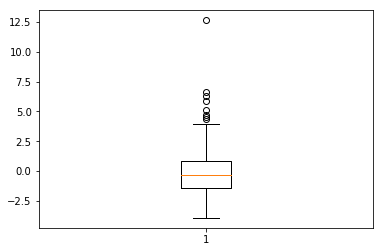

In [73]:
plt.boxplot(gdpcad.PC1)

{'whiskers': [<matplotlib.lines.Line2D at 0x263eb6a4400>,
 'caps': [<matplotlib.lines.Line2D at 0x263eb695780>,
 'boxes': [<matplotlib.lines.Line2D at 0x263eb6a4550>],
 'medians': [<matplotlib.lines.Line2D at 0x263eb695278>],
 'fliers': [<matplotlib.lines.Line2D at 0x263eb6959e8>],
 'means': []}

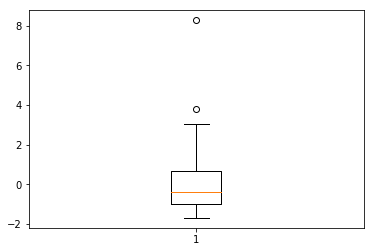

In [74]:
plt.boxplot(gdpcad.PC2)

{'whiskers': [<matplotlib.lines.Line2D at 0x263eb45a390>,
 'caps': [<matplotlib.lines.Line2D at 0x263eb462eb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x263eb45aef0>],
 'medians': [<matplotlib.lines.Line2D at 0x263eb4624a8>],
 'fliers': [<matplotlib.lines.Line2D at 0x263eb462a90>],
 'means': []}

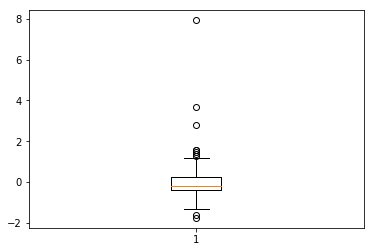

In [75]:
plt.boxplot(gdpcad.PC3)

{'whiskers': [<matplotlib.lines.Line2D at 0x263eb364a20>,
 'caps': [<matplotlib.lines.Line2D at 0x263eb364e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x263eb364438>],
 'medians': [<matplotlib.lines.Line2D at 0x263eb35a630>],
 'fliers': [<matplotlib.lines.Line2D at 0x263eb35a828>],
 'means': []}

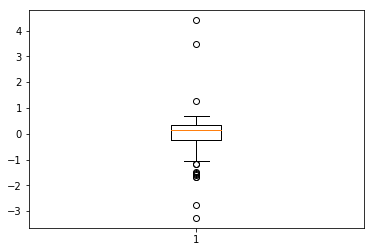

In [76]:
plt.boxplot(gdpcad.PC4)

{'whiskers': [<matplotlib.lines.Line2D at 0x263eaad2470>,
 'caps': [<matplotlib.lines.Line2D at 0x263eb6606a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x263eb12e198>],
 'medians': [<matplotlib.lines.Line2D at 0x263eb660710>],
 'fliers': [<matplotlib.lines.Line2D at 0x263eb4729e8>],
 'means': []}

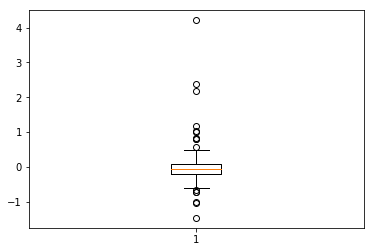

In [77]:
plt.boxplot(gdpcad.PC5)

We can see that outliers exist in all the components. Usually we remove the outliers above 95 percentile and below 5 quantile however, I will remove the outliers only above 95 percentile for all components except, 'PC2',  as we would be interested in cluster of countries with lower than usual values, as these would probably consist of countries that require the funding most. 'PC2' explains the highest variance in the direction of 'child_mort' which would be high for countries that are in need of aids. Therefore, will remove the lower than usual quantile values for 'PC2'.

In [81]:
gdpcad.shape

(167, 6)

In [79]:
gdpcad['country'] = gdp['country']

In [80]:
gdpcad.head()

,PC1,PC2,PC3,PC4,PC5,country
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529,Afghanistan
1,-0.024205,-1.429891,-0.014123,0.450644,-0.125822,Albania
2,-0.459558,-0.675496,0.959355,0.218456,-0.113276,Algeria
3,-2.722631,2.172331,0.600215,-0.433976,0.005434,Angola
4,0.648597,-1.023437,-0.257430,0.289201,0.072694,Antigua and Barbuda


In [89]:
gdpcad = gdpcad[gdpcad.PC1 <= gdpcad.PC1.quantile(0.95)]

In [90]:
gdpcad = gdpcad[gdpcad.PC3 <= gdpcad.PC3.quantile(0.95)]

In [91]:
gdpcad = gdpcad[gdpcad.PC4 <= gdpcad.PC4.quantile(0.95)]

In [92]:
gdpcad = gdpcad[gdpcad.PC5 <= gdpcad.PC5.quantile(0.95)]

In [93]:
gdpcad = gdpcad[gdpcad.PC2 >= gdpcad.PC2.quantile(0.05)]

In [94]:
gdpcad.shape

(127, 6)

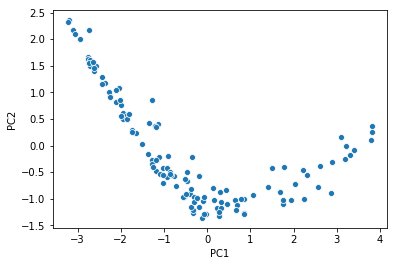

In [98]:
#Visualising the points on the PCs.
# one of the prime advatanges of PCA is that you can visualise high dimensional data
sns.scatterplot(x='PC1',y='PC2',data=gdpcad)

Clustering
Now that we have PCs that can be used to identify the clusters in best possible way, we will do the clustering. First clustering will be done using K-means clustering 

K-means clustering
First, will run hopkins test to see whether the dataset has enough variance between variables to form clusters

In [99]:
gdpcadk = gdpcad[['PC1','PC2','PC3','PC4','PC5']]

In [100]:
gdpcadk.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529
2,-0.459558,-0.675496,0.959355,0.218456,-0.113276
3,-2.722631,2.172331,0.600215,-0.433976,0.005434
4,0.648597,-1.023437,-0.257430,0.289201,0.072694
6,-0.334555,-1.271889,0.190564,0.500247,-0.205703


In [103]:
#Calculating the Hopkins statistic
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [104]:
#Hopkins measure score
hopkins(gdpcadk)

0.8435394312098518

We ca see that high hopkins score of .84 or around 84% justifies clustering based model for this dataset. Ideally score should be above 50% so the score achieved is well above the baseline

K-means clustering
First step is to check for optimum number of clusters using elbow curve and silhoutte score

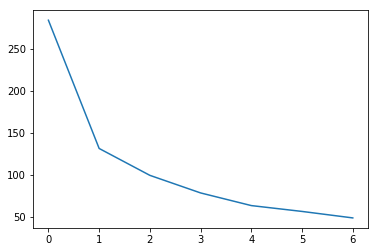

In [106]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(gdpcadk)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [111]:
# Now silhoutte score
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter = 50).fit(gdpcadk)
    sse.append([k, silhouette_score(gdpcadk, kmeans.labels_)])


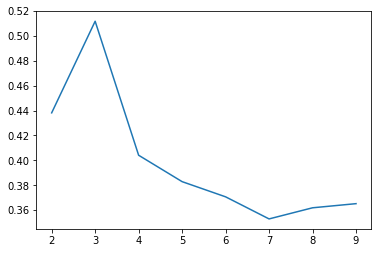

In [112]:
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1])

From both, elbow curve and silhoutte score, the ideal number of clusters come out to be '3'

In [139]:
# Performing K means using K=3
model_k = KMeans(n_clusters = 3, max_iter=50,random_state = 50)
model_k.fit(gdpcadk)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=50, tol=0.0001, verbose=0)

In [140]:
gdpcadkl=gdpcadk
gdpcadkl.index = pd.RangeIndex(len(gdpcadkl.index))
gdpcadkl = pd.concat([gdpcadkl, pd.Series(model_k.labels_)], axis=1)
gdpcadkl.head()

,PC1,PC2,PC3,PC4,PC5,0
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
1,-0.459558,-0.675496,0.959355,0.218456,-0.113276,1
2,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
3,0.648597,-1.023437,-0.257430,0.289201,0.072694,1
4,-0.334555,-1.271889,0.190564,0.500247,-0.205703,1


In [142]:
gdpcadkl.head()

,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
1,-0.459558,-0.675496,0.959355,0.218456,-0.113276,1
2,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
3,0.648597,-1.023437,-0.257430,0.289201,0.072694,1
4,-0.334555,-1.271889,0.190564,0.500247,-0.205703,1


In [141]:
gdpcadkl.columns = ['PC1','PC2','PC3','PC4','PC5','Cluster_Id'] 

In [143]:
gdpcadkl.head()

,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
1,-0.459558,-0.675496,0.959355,0.218456,-0.113276,1
2,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
3,0.648597,-1.023437,-0.257430,0.289201,0.072694,1
4,-0.334555,-1.271889,0.190564,0.500247,-0.205703,1


In [119]:
gdpcadkl['Cluster_Id'].value_counts()

1    62
0    43
2    22
Name: Cluster_Id, dtype: int64

In [144]:
gdpcadkl.isnull().sum()

PC1           0
PC2           0
PC3           0
PC4           0
PC5           0
Cluster_Id    0
dtype: int64

So we can see the distribution of PCS in the three clusters


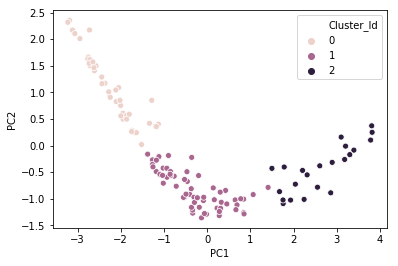

In [120]:
# Plotting scatterplot to see the distribution of the first two PCS within the clusters 
sns.scatterplot(x='PC1',y='PC2',hue='Cluster_Id',legend='full',data=gdpcadkl)

It can be seen from above that cluster-2 consist mainly PC1 components while cluster-0 consist of mainly PC2 components. 
Cluster-1 probably consists of other PCs as both PC2 and PC1 have low values for this cluster

In [293]:
gdpcadkl.Cluster_Id.value_counts()

1    62
0    43
2    22
Name: Cluster_Id, dtype: int64

In [145]:
gdpcadkl.shape

(127, 6)

In [146]:
gdpcad.shape

(127, 6)

In [147]:
gdpcadkl.head()

,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
1,-0.459558,-0.675496,0.959355,0.218456,-0.113276,1
2,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
3,0.648597,-1.023437,-0.257430,0.289201,0.072694,1
4,-0.334555,-1.271889,0.190564,0.500247,-0.205703,1


In [148]:
gdpcad.head()

,PC1,PC2,PC3,PC4,PC5,country
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529,Afghanistan
2,-0.459558,-0.675496,0.959355,0.218456,-0.113276,Algeria
3,-2.722631,2.172331,0.600215,-0.433976,0.005434,Angola
4,0.648597,-1.023437,-0.257430,0.289201,0.072694,Antigua and Barbuda
6,-0.334555,-1.271889,0.190564,0.500247,-0.205703,Armenia


In [149]:
gdpcad.isnull().sum()

PC1        0
PC2        0
PC3        0
PC4        0
PC5        0
country    0
dtype: int64

In [150]:
gdpcad.index = pd.RangeIndex(len(gdpcad.index))

In [151]:
gdpcadkl['country'] = gdpcad['country']

In [153]:
gdpcadkl.shape

(127, 7)

In [154]:
gdpcadkl.isnull().sum()

PC1           0
PC2           0
PC3           0
PC4           0
PC5           0
Cluster_Id    0
country       0
dtype: int64

Now will merge this dataset with cluster Ids with main dataset on 'country' column. Will do the inner join so that merged dataset only consists of countries that are common to both datasets

In [155]:
gdpcadf = pd.merge(gdp, gdpcadkl, how = 'inner', on = 'country')

In [156]:
gdpcadf.shape

(127, 16)

In [157]:
gdpcadf.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
1,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,-0.459558,-0.675496,0.959355,0.218456,-0.113276,1
2,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
3,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0.648597,-1.023437,-0.257430,0.289201,0.072694,1
4,Armenia,18.1,669.76,141.68,1458.66,6700,7.77,73.3,1.69,3220,-0.334555,-1.271889,0.190564,0.500247,-0.205703,1


In [158]:
gdpcadf.isnull().sum(axis = 0)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
PC1           0
PC2           0
PC3           0
PC4           0
PC5           0
Cluster_Id    0
dtype: int64

Boxplot analysis

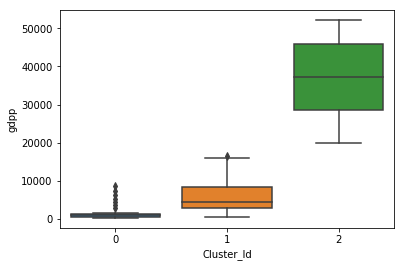

In [164]:
sns.boxplot(x = 'Cluster_Id', y = 'gdpp', data = gdpcadf)

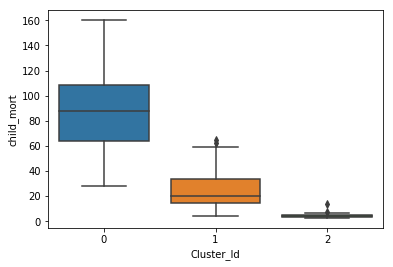

In [165]:
sns.boxplot(x = 'Cluster_Id', y = 'child_mort', data = gdpcadf)

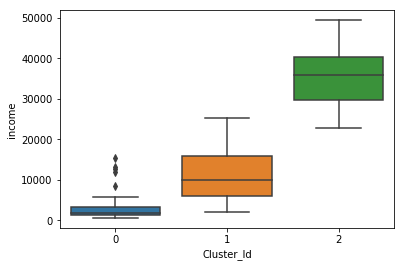

In [166]:
sns.boxplot(x = 'Cluster_Id', y = 'income', data = gdpcadf)

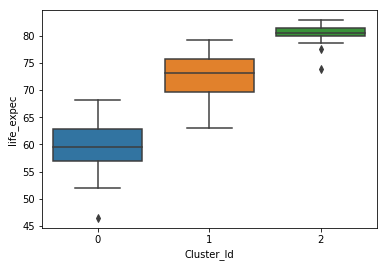

In [167]:
sns.boxplot(x = 'Cluster_Id', y = 'life_expec', data = gdpcadf)

It can be seen from above box plots that cluster -0 has the countries due to the following analysis results:
1. The 'gdpp' is lowest for this cluster. Therefore, the spending on 'health', 'imports' and 'exports' is least and in fact GDP per capita, given by 'gdpp' is quite low
2. The 'child_mort' rate is highest for this cluster and again, alarmingly high and countries within this cluster need the most attention
3. The 'income' is lowest for this cluster so the spending power of an individual from countries within this cluster is lowest which means that access to basic needs is toughest for people of these countries 

Now will create a dataframe with countries from cluster-0 only

In [168]:
gdpcadf_0 = gdpcadf[gdpcadf.Cluster_Id == 0]

In [169]:
gdpcadf_0.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.440,56.2,5.82,553,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
2,Angola,119.0,2199.19,100.60,1514.37,5900,22.400,60.1,6.16,3530,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
12,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758,-2.363962,1.171696,-1.247192,-0.257107,0.107725,0
15,Botswana,52.5,2768.60,527.05,3257.55,13300,8.920,57.1,2.88,6350,-1.129489,0.401611,-0.231994,0.102648,0.278407,0
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575,-2.751479,1.664992,-0.848207,-0.345047,0.087575,0


In [174]:
gdpcadf_0.shape

(43, 16)

Dropping the principle component columns as we do not need them now

In [170]:
gdpf_0 = gdpcadf_0.drop(['PC1','PC2', 'PC3', 'PC4', 'PC5'], axis = 1)

In [171]:
gdpf_0.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.440,56.2,5.82,553,0
2,Angola,119.0,2199.19,100.60,1514.37,5900,22.400,60.1,6.16,3530,0
12,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758,0
15,Botswana,52.5,2768.60,527.05,3257.55,13300,8.920,57.1,2.88,6350,0
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575,0


In [172]:
gdpf_0.shape

(43, 11)

In [176]:
gdpf_0.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.0
mean,86.900000,620.945116,98.498605,643.552558,3348.488372,9.508721,59.800000,4.972093,1569.860465,0.0
std,28.815323,1015.885953,137.341978,753.133632,3608.961725,6.623224,4.585588,1.038973,1951.316071,0.0
min,28.100000,20.610000,12.820000,90.550000,609.000000,0.885000,46.500000,2.590000,231.000000,0.0
25%,63.650000,107.525000,33.330000,193.060000,1390.000000,4.010000,56.950000,4.440000,550.000000,0.0
50%,88.200000,196.340000,50.960000,302.800000,1870.000000,8.790000,59.500000,5.020000,897.000000,0.0
75%,108.500000,500.590000,77.185000,667.845000,3345.000000,15.050000,62.850000,5.495000,1310.000000,0.0
max,160.000000,5048.750000,650.830000,3257.550000,15400.000000,23.600000,68.200000,7.490000,8750.000000,0.0


Lets shortlist first the countries within this group that have values of 'gdpp', 'income' lower than their mean as described above, and, have 'child_mort' higher than the mean value  

In [223]:
gdpfl = gdpf_0[gdpf_0.child_mort >= 86.9]

In [224]:
gdpfl = gdpf_0[gdpf_0.gdpp <= 1569.86]

In [225]:
gdpfl = gdpf_0[gdpf_0.income <= 3348.49]

In [226]:
gdpfl.shape

(32, 11)

In [197]:
gdpfl

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.440,56.2,5.82,553,0
12,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758,0
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575,0
19,Burundi,93.6,20.61,26.80,90.55,764,12.300,57.7,6.26,231,0
21,Cameroon,108.0,290.82,67.20,353.70,2660,1.910,57.3,5.11,1310,0
24,Chad,150.0,330.10,40.63,390.20,1930,6.390,56.5,6.59,897,0
28,Comoros,88.2,126.88,34.68,397.57,1410,3.870,65.9,4.75,769,0
29,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.800,57.5,6.54,334,0
31,Cote d'Ivoire,111.0,617.32,64.66,528.26,2690,5.390,56.3,5.27,1220,0
39,Eritrea,55.2,23.09,12.82,112.31,1420,11.600,61.7,4.61,482,0


In [215]:
gdpfl.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.0
mean,93.343750,212.123125,50.554375,362.493125,1716.406250,7.826406,58.996875,5.263438,756.06250,0.0
std,28.155879,179.714705,33.266689,292.820496,732.826691,5.712774,4.439303,0.873098,371.33716,0.0
min,28.100000,20.610000,12.820000,90.550000,609.000000,0.885000,46.500000,3.300000,231.00000,0.0
25%,74.000000,96.680000,31.732500,170.702500,1217.500000,2.880000,56.450000,4.715000,476.25000,0.0
50%,90.400000,135.515000,41.275000,264.065000,1575.000000,6.600000,58.750000,5.235000,621.50000,0.0
75%,111.000000,259.455000,57.230000,398.927500,2112.500000,11.725000,61.725000,5.737500,1042.50000,0.0
max,160.000000,635.970000,168.370000,1190.510000,3320.000000,20.800000,68.200000,7.490000,1490.00000,0.0


Boxplot analysis of 'child_mort', 'income' and 'gdpp' to visulaize whether any outliers can be removed to further filter the countries 

{'whiskers': [<matplotlib.lines.Line2D at 0x263ebc34f98>,
 'caps': [<matplotlib.lines.Line2D at 0x263ebc3d668>,
 'boxes': [<matplotlib.lines.Line2D at 0x263ebc1fef0>],
 'medians': [<matplotlib.lines.Line2D at 0x263ebc3dcf8>],
 'fliers': [<matplotlib.lines.Line2D at 0x263ebc3ddd8>],
 'means': []}

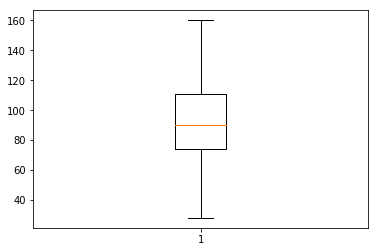

In [199]:
plt.boxplot(gdpfl.child_mort)

{'whiskers': [<matplotlib.lines.Line2D at 0x263ebcdfd30>,
 'caps': [<matplotlib.lines.Line2D at 0x263ebceb6d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x263ebcdfbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x263ebcebd68>],
 'fliers': [<matplotlib.lines.Line2D at 0x263ebcebe48>],
 'means': []}

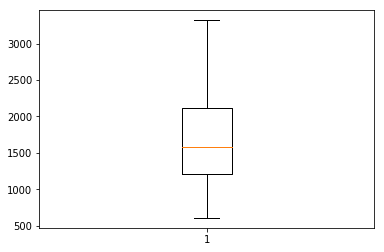

In [201]:
plt.boxplot(gdpfl.income)

{'whiskers': [<matplotlib.lines.Line2D at 0x263ebbd5400>,
 'caps': [<matplotlib.lines.Line2D at 0x263ebbd5a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x263ebbcbf98>],
 'medians': [<matplotlib.lines.Line2D at 0x263ebbd5eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x263ebbdf4a8>],
 'means': []}

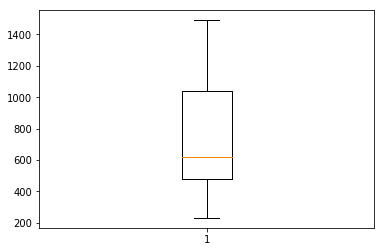

In [188]:
plt.boxplot(gdpfl.gdpp)

There seems to be no outliers for the three main variables. 
Will filter based on 'total_fer' being greater than the mean and 'income' being lower than the mean. This is because such countries would have the most number of children with parental income being lowest and therefore, would require financial aid most urgently

In [227]:
gdpfl = gdpfl[gdpfl.income <= 1716.41]

In [228]:
gdpfl = gdpfl[gdpfl.total_fer >= 5]

In [229]:
gdpfl

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.81,57.9,5.87,575,0
19,Burundi,93.6,20.61,26.80,90.55,764,12.30,57.7,6.26,231,0
29,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.80,57.5,6.54,334,0
45,Gambia,80.3,133.76,31.98,239.97,1660,4.30,65.5,5.71,562,0
52,Guinea,109.0,196.34,31.95,279.94,1190,16.10,58.0,5.34,648,0
53,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.97,55.6,5.05,547,0
72,Liberia,89.3,62.46,38.59,302.80,700,5.47,60.8,5.02,327,0
75,Malawi,90.5,104.65,30.25,160.19,1030,12.10,53.1,5.31,459,0
83,Mozambique,101.0,131.99,21.83,193.58,918,7.64,54.5,5.56,419,0


In [231]:
gdpfl.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0
mean,104.915385,98.485385,35.295385,194.033077,1144.230769,9.867692,57.492308,5.793846,461.307692,0.0
std,21.786343,45.270507,11.166412,59.004819,364.138745,5.697339,3.128221,0.694677,128.240259,0.0
min,80.300000,20.610000,17.960000,90.550000,609.000000,2.550000,53.100000,5.020000,231.000000,0.0
25%,90.200000,67.030000,26.800000,165.660000,814.000000,5.470000,55.600000,5.310000,348.000000,0.0
50%,101.000000,101.740000,31.980000,170.870000,1190.000000,9.440000,57.500000,5.710000,459.000000,0.0
75%,116.000000,131.990000,41.920000,239.970000,1430.000000,12.300000,58.000000,6.150000,562.000000,0.0
max,160.000000,196.340000,53.610000,302.800000,1660.000000,20.800000,65.500000,7.490000,648.000000,0.0


We can still filter countries further based on 'child_mort' to reduce the list that would consist of countries that are in dire need of funds. The 'income' and 'gdpp' are too low for all the countries so not fair to reduce the list of primary candidates for aid based these parameters 

In [232]:
gdpfl = gdpfl[gdpfl.child_mort >= 105]

In [233]:
gdpfl

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.81,57.9,5.87,575,0
29,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.80,57.5,6.54,334,0
52,Guinea,109.0,196.34,31.95,279.94,1190,16.10,58.0,5.34,648,0
53,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.97,55.6,5.05,547,0
88,Niger,123.0,77.26,17.96,170.87,814,2.55,58.8,7.49,348,0
101,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,0


In [238]:
list1 = list(gdpfl.country)

In [240]:
print("The list of countries that need the aid most are ",list1)

The list of countries that need the aid most are  ['Burkina Faso', 'Congo, Dem. Rep.', 'Guinea', 'Guinea-Bissau', 'Niger', 'Sierra Leone']


Clustering by Hierarchical Clustering
We have already reduced the dimensions using PCA and checked via high 'hopkins' score that dataset 'gdpcadk' is good for clustering
Therefore, will straightaway use the Hierarchical Clustering model (single linkage and complete linkage) to calculate the clusters  

In [241]:
gdpcadk.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529
1,-0.459558,-0.675496,0.959355,0.218456,-0.113276
2,-2.722631,2.172331,0.600215,-0.433976,0.005434
3,0.648597,-1.023437,-0.257430,0.289201,0.072694
4,-0.334555,-1.271889,0.190564,0.500247,-0.205703


In [251]:
gdpcadk.shape

(127, 5)

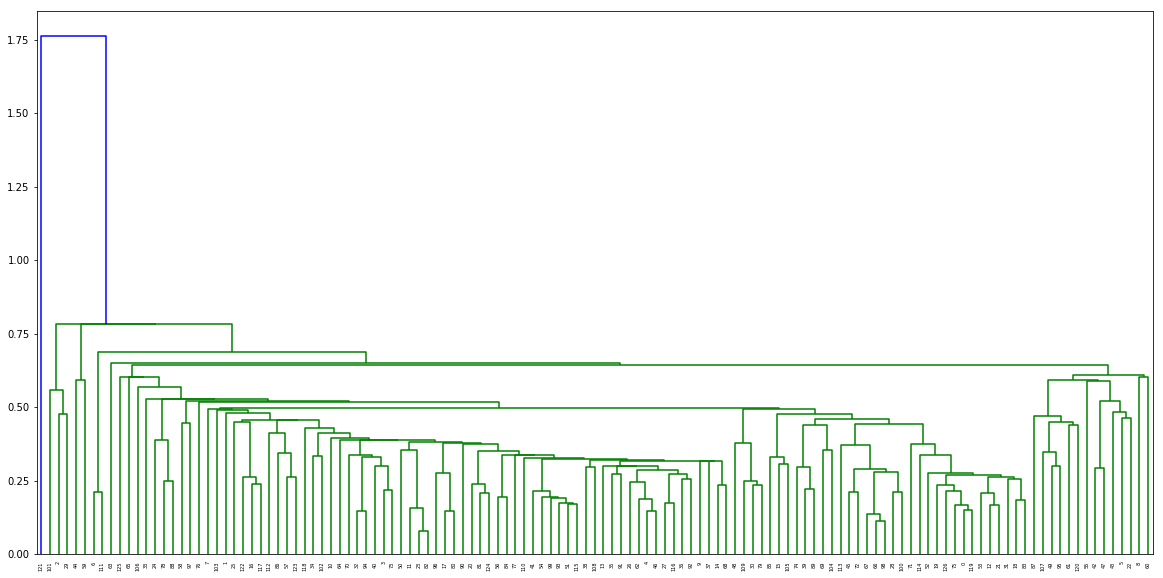

In [245]:
#Single linkage
%matplotlib inline
plt.figure(figsize = (20,10))
lk = linkage(gdpcadk, method = 'single', metric = 'euclidean')
dendrogram(lk)
plt.show()

The dendrogram above, using single linkage, isn't too intuitive or clear to assess the correct number of clusters
Will now plot the dendrogram using complete linkage

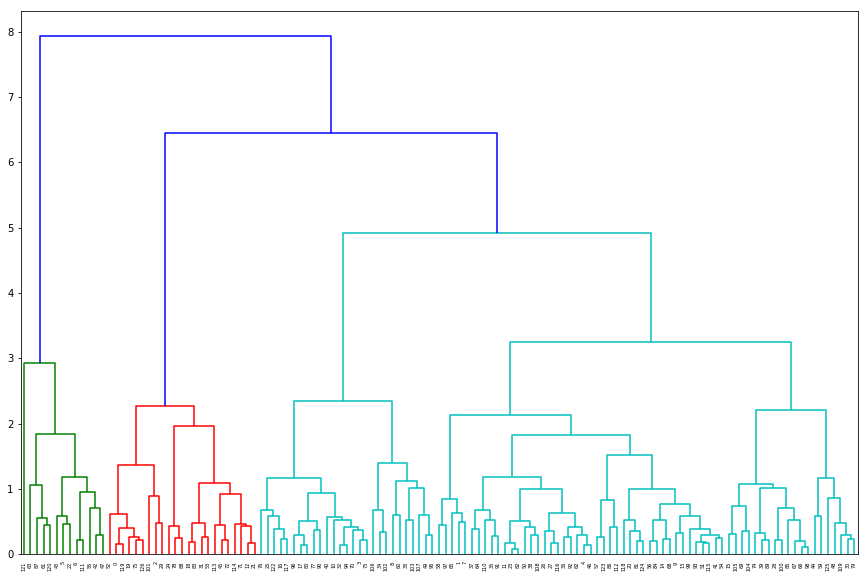

In [246]:
#Complete linkage
plt.figure(figsize = (15,10))
cclk = linkage(gdpcadk, method = 'complete', metric = 'euclidean')
dendrogram(cclk)
plt.show()

As expected, dendrogram from 'complete' linkage clearly shows the links between the clusters and the resulting inverted tree that is formed
We can clearly see that cutting the tree at point '7' would result in clusters with best linkages as the link 'distance' is maximum. The number of resulting clusters are '3'

In [247]:
Cluster_Id = cut_tree(cclk,n_clusters = 3)

In [248]:
Cluster_Id.shape

(127, 1)

In [250]:
Cluster_Id.reshape(-1, )

array([0, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0])

In [253]:
gdpcadhc=gdpcadk
gdpcadhc['Cluster_Id'] = Cluster_Id 

In [254]:
gdpcadhc.head()

,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
1,-0.459558,-0.675496,0.959355,0.218456,-0.113276,1
2,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
3,0.648597,-1.023437,-0.257430,0.289201,0.072694,1
4,-0.334555,-1.271889,0.190564,0.500247,-0.205703,1


In [255]:
gdpcadhc.shape

(127, 6)

In [259]:
gdpcadhc.isnull().sum()

PC1           0
PC2           0
PC3           0
PC4           0
PC5           0
Cluster_Id    0
country       0
dtype: int64

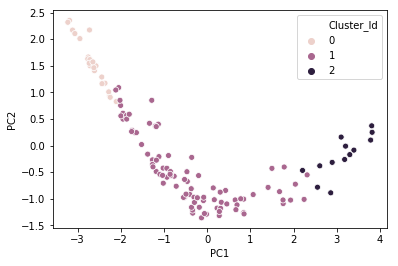

In [292]:
# Plotting scatterplot to see the distribution of the first two PCS within the clusters 
sns.scatterplot(x='PC1',y='PC2',hue='Cluster_Id',legend='full',data=gdpcadhc)

It can be seen from above that the three clusters formed in the case of 'hierarchy clustering' differ slightly from those formed in the case of K-means algorithm with respect to the size of the clusters. The cluster-0 in this case is quite smaller and the cluster - '1' larger when compared to the ones that were formed in K-means clustering

In [257]:
gdpcadhc['country'] = gdpcad['country']

In [258]:
gdpcadhc.shape

(127, 7)

Now will merge this dataset with cluster Ids with main dataset on 'country' column. Will do the inner join so that merged dataset only consists of countries that are common to both datasets

In [260]:
gdpcadhcf = pd.merge(gdp, gdpcadhc, how = 'inner', on = 'country')

In [261]:
gdpcadhcf.shape

(127, 16)

In [262]:
gdpcadhcf.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
1,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,-0.459558,-0.675496,0.959355,0.218456,-0.113276,1
2,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
3,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0.648597,-1.023437,-0.257430,0.289201,0.072694,1
4,Armenia,18.1,669.76,141.68,1458.66,6700,7.77,73.3,1.69,3220,-0.334555,-1.271889,0.190564,0.500247,-0.205703,1


In [263]:
gdpcadhcf.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
PC1           0
PC2           0
PC3           0
PC4           0
PC5           0
Cluster_Id    0
dtype: int64

In [273]:
gdpcadhcf.Cluster_Id.value_counts()

1    91
0    23
2    13
Name: Cluster_Id, dtype: int64

Boxplot analysis

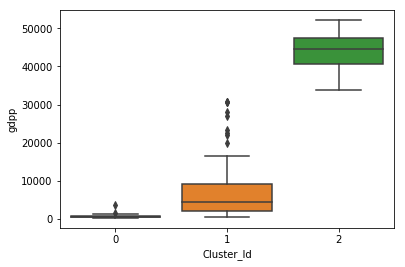

In [267]:
sns.boxplot(x = 'Cluster_Id', y = 'gdpp', data = gdpcadhcf)

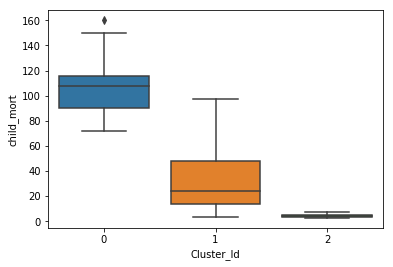

In [268]:
sns.boxplot(x = 'Cluster_Id', y = 'child_mort', data = gdpcadhcf)

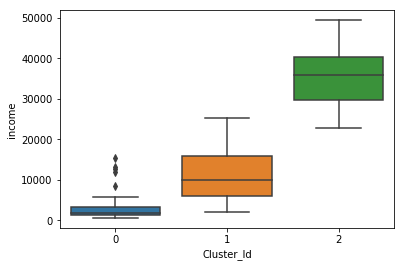

In [166]:
sns.boxplot(x = 'Cluster_Id', y = 'income', data = gdpcadhcf)

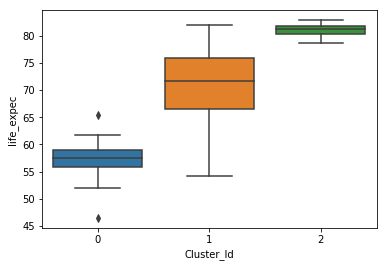

In [269]:
sns.boxplot(x = 'Cluster_Id', y = 'life_expec', data = gdpcadhcf)

It can be seen that the box plot analysis for clusters based on 'Hierarchy clustering' produces the same results as in the case of 'K-means' clustering performed above. Therefore, will focus on cluster-0 here too

In [270]:
gdpcadhcf_0 = gdpcadhcf[gdpcadhcf.Cluster_Id == 0]

In [271]:
gdpcadhcf_0.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,PC5,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.440,56.2,5.82,553,-2.635574,1.472268,-0.549489,-0.242326,0.023529,0
2,Angola,119.0,2199.19,100.60,1514.37,5900,22.400,60.1,6.16,3530,-2.722631,2.172331,0.600215,-0.433976,0.005434,0
12,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758,-2.363962,1.171696,-1.247192,-0.257107,0.107725,0
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575,-2.751479,1.664992,-0.848207,-0.345047,0.087575,0
19,Burundi,93.6,20.61,26.80,90.55,764,12.300,57.7,6.26,231,-2.762439,1.628790,-0.299329,-0.309939,-0.066405,0


In [272]:
gdpcadhcf_0.shape

(23, 16)

Dropping the principle component columns as we do not need them now

In [274]:
gdphcf_0 = gdpcadhcf_0.drop(['PC1','PC2', 'PC3', 'PC4', 'PC5'], axis = 1)

In [275]:
gdphcf_0.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.440,56.2,5.82,553,0
2,Angola,119.0,2199.19,100.60,1514.37,5900,22.400,60.1,6.16,3530,0
12,Benin,111.0,180.40,31.08,281.98,1820,0.885,61.8,5.36,758,0
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.810,57.9,5.87,575,0
19,Burundi,93.6,20.61,26.80,90.55,764,12.300,57.7,6.26,231,0


In [276]:
gdphcf_0.shape

(23, 11)

In [277]:
gdphcf_0.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0
mean,106.300000,277.747391,47.55000,345.921304,1769.782609,8.617609,57.191304,5.624348,793.043478,0.0
std,22.158889,447.522587,26.79833,336.415781,1137.850763,6.188847,3.710539,0.819101,683.439861,0.0
min,71.900000,20.610000,17.96000,90.550000,609.000000,0.885000,46.500000,3.300000,231.000000,0.0
25%,90.250000,91.620000,31.51500,170.535000,1110.000000,4.225000,55.900000,5.235000,439.000000,0.0
50%,108.000000,133.760000,38.76000,248.300000,1540.000000,6.810000,57.500000,5.430000,575.000000,0.0
75%,116.000000,243.580000,52.94000,328.250000,2010.000000,12.200000,59.050000,6.155000,827.500000,0.0
max,160.000000,2199.190000,129.87000,1514.370000,5900.000000,22.400000,65.500000,7.490000,3530.000000,0.0


Lets shortlist first the countries within this group that have values of 'gdpp', 'income' lower than their mean as described above, and, have 'child_mort' higher than the mean value  

In [278]:
gdphcfl = gdphcf_0[gdphcf_0.child_mort >= 106]

In [279]:
gdphcfl = gdphcf_0[gdphcf_0.gdpp <= 793]

In [280]:
gdphcfl = gdphcf_0[gdphcf_0.income <= 1770]

In [281]:
gdphcfl.shape

(14, 11)

In [283]:
gdphcfl

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.81,57.9,5.87,575,0
19,Burundi,93.6,20.61,26.80,90.55,764,12.30,57.7,6.26,231,0
29,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.80,57.5,6.54,334,0
45,Gambia,80.3,133.76,31.98,239.97,1660,4.30,65.5,5.71,562,0
52,Guinea,109.0,196.34,31.95,279.94,1190,16.10,58.0,5.34,648,0
53,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.97,55.6,5.05,547,0
72,Liberia,89.3,62.46,38.59,302.80,700,5.47,60.8,5.02,327,0
75,Malawi,90.5,104.65,30.25,160.19,1030,12.10,53.1,5.31,459,0
83,Mozambique,101.0,131.99,21.83,193.58,918,7.64,54.5,5.56,419,0


In [284]:
gdphcfl = gdphcfl[gdphcfl.total_fer >= 5]

In [285]:
gdphcfl.shape

(13, 11)

In [286]:
gdphcfl.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.0
mean,104.915385,98.485385,35.295385,194.033077,1144.230769,9.867692,57.492308,5.793846,461.307692,0.0
std,21.786343,45.270507,11.166412,59.004819,364.138745,5.697339,3.128221,0.694677,128.240259,0.0
min,80.300000,20.610000,17.960000,90.550000,609.000000,2.550000,53.100000,5.020000,231.000000,0.0
25%,90.200000,67.030000,26.800000,165.660000,814.000000,5.470000,55.600000,5.310000,348.000000,0.0
50%,101.000000,101.740000,31.980000,170.870000,1190.000000,9.440000,57.500000,5.710000,459.000000,0.0
75%,116.000000,131.990000,41.920000,239.970000,1430.000000,12.300000,58.000000,6.150000,562.000000,0.0
max,160.000000,196.340000,53.610000,302.800000,1660.000000,20.800000,65.500000,7.490000,648.000000,0.0


We can still filter countries further based on 'child_mort' to reduce the list that would consist of countries that are in dire need of funds. The 'income' and 'gdpp' are too low for all the countries so not fair to reduce the list of primary candidates for aid based these parameters 

In [287]:
gdphcfl = gdphcfl[gdphcfl.child_mort >= 105]

In [288]:
gdphcfl.shape

(6, 11)

In [289]:
gdphcfl

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
18,Burkina Faso,116.0,110.40,38.76,170.20,1430,6.81,57.9,5.87,575,0
29,"Congo, Dem. Rep.",116.0,137.27,26.42,165.66,609,20.80,57.5,6.54,334,0
52,Guinea,109.0,196.34,31.95,279.94,1190,16.10,58.0,5.34,648,0
53,Guinea-Bissau,114.0,81.50,46.50,192.54,1390,2.97,55.6,5.05,547,0
88,Niger,123.0,77.26,17.96,170.87,814,2.55,58.8,7.49,348,0
101,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,0


In [290]:
list2 = list(gdphcfl.country)

In [291]:
print("The list of countries that need the aid most as per 'hierrachy clustering' are ",list2)

The list of countries that need the aid most as per 'hierrachy clustering' are  ['Burkina Faso', 'Congo, Dem. Rep.', 'Guinea', 'Guinea-Bissau', 'Niger', 'Sierra Leone']


The results from both type of clustering is the same in this case and so the shortlisted countries that require the aid on most urgent basis are the following:
1. Burkina Faso
2. Congo, Dem. Rep.
3. Guinea
4. Guinea-Bissau
5. Niger
6. Sierra Leone